# Importing Libraries and Reading Data 

In [240]:
import pandas as pd
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option("display.max_rows",None)
pd.set_option("display.max_columns",None)
pd.set_option('display.max_colwidth',None)
pd.set_option('display.float_format', lambda x: '%.1f' % x)
from tqdm import tqdm

import scipy.stats as stats
import plotly.express as px
from plotly.offline import iplot
import plotly.figure_factory as ff

import warnings
warnings.filterwarnings('ignore')



In [3]:
df = pd.read_excel (r'250_IMDB_modified.xlsx')
print(df.shape)
print(df.columns)
display(df.head())

(250, 17)
Index(['Name', 'Year', 'Month', 'duration', 'Cast', 'Director', 'Users',
       'Production', 'Genre', 'Budget', 'US_Canada_Collection',
       'Weekend_Collection', 'Worlwide_Collection', 'Meta_Score',
       'Origin_Currency_Symbol', 'Rating', 'origin_country'],
      dtype='object')


,Name,Year,Month,duration,Cast,Director,Users,Production,Genre,Budget,US_Canada_Collection,Weekend_Collection,Worlwide_Collection,Meta_Score,Origin_Currency_Symbol,Rating,origin_country
0,The Shawshank Redemption,1994,10,142,"Tim Robbins, Morgan Freeman",Frank Darabont,2647119,Castle Rock Entertainment,Drama,25000000.0,28767189.0,727327.0,28884504.0,81.0,"$25,000,000 (estimated)",9.2,['United States']
1,The Godfather,1972,3,175,"Marlon Brando, Al Pacino",Francis Ford Coppola,1834912,Paramount Pictures,Crime,6000000.0,136381073.0,302393.0,250341816.0,100.0,"$6,000,000 (estimated)",9.2,['United States']
2,The Dark Knight,2008,7,152,"Christian Bale, Heath Ledger",Christopher Nolan,2619064,Warner Bros.,Action,185000000.0,534987076.0,158411483.0,1006234167.0,84.0,"$185,000,000 (estimated)",9.0,"['United States', 'United Kingdom']"
3,The Godfather Part II,1974,12,202,"Al Pacino, Robert De Niro",Francis Ford Coppola,1257549,Paramount Pictures,Crime,13000000.0,47834595.0,171417.0,47961919.0,90.0,"$13,000,000 (estimated)",9.0,['United States']
4,12 Angry Men,1957,4,96,"Henry Fonda, Lee J. Cobb",Sidney Lumet,781551,Orion-Nova Productions,Crime,350000.0,nan,nan,955.0,96.0,"$350,000 (estimated)",8.9,['United States']


# Cleaning and Feature Engineering

###  Making Budget to the same Scale

In [6]:
#(Making Budget same scale), This should always be the first step before the null value imputation (we call this here as cleaning
#Feature Engineering:  Creating Country column

# before thi we need to filll the null value in Origin_Currency_Symbol

# Create a boolean mask where True indicates the value in Origin_Currency_Symbol is None
mask = df['Origin_Currency_Symbol'].isna()

# Use the mask to filter the DataFrame
rows_with_none = df[mask]
distinct_origin_countries =rows_with_none['origin_country'].unique() # to get an idea for below mapping


# Assuming df is your DataFrame

# Mapping of country to currency symbol
country_to_currency_symbol = {
    'Japan': '¥',
    'Germany': '€',
    'United States': '$',
    'India': '₹',
    'United Kingdom': '£',
    'Sweden': 'SEK',
    'France': '€',
    'Italy': '€',
    'Turkey': 'TRY',
    'Soviet Union': 'SUR',
    'France, Italy': '€'
}

# Function to fill the currency symbol based on the country
def fill_currency_symbol(row):
    if pd.isna(row['Origin_Currency_Symbol']):
        country = row['origin_country']
        # Strip and remove brackets from the country name
        country = country.strip("[]").replace("'", "")
        return country_to_currency_symbol.get(country)
    else:
        return row['Origin_Currency_Symbol']

# Apply the function to each row where Origin_Currency_Symbol is null
mask = df['Origin_Currency_Symbol'].isnull()
df.loc[mask, 'Origin_Currency_Symbol'] = df.loc[mask].apply(fill_currency_symbol, axis=1)


# creating symbol list
symbol=[]
for i in range(df.shape[0]):
    a = re.findall(r'\D',df['Origin_Currency_Symbol'][i])
    b= df['Origin_Currency_Symbol'][i]
    
    if '$' in a :
        symbol.append(1)
        
    elif ('M' in a and 'V' in a and 'R' in a ):
        symbol.append(1400000) # the budget for movie: Blade Runner(1982) was 28000000. 20 *x = 28000000
        
    elif '£' in a :
        symbol.append(1.55)
        
    elif '₹' in a :
        symbol.append(0.022)
        
    elif '€' in a :
        symbol.append(1.33)
        
    elif 'D' in a and 'E' in a and 'M' in a:
        symbol.append(0.454) #1 US Dollar was equivalent to 2.2 approx , there are 2 movies :1981 nd 1921, for both.
    
    elif '¥' in a :
        symbol.append(0.0069)
    
    elif ('F' in a and 'R' in a and 'F' in a) : #1 US Dollar was equivalent to 5.4 French Francs in 90's, so 1 FRF = 1 / 5.4 USD = 0.185 usd
        symbol.append(0.185)
        
    elif '₩' in a :
        symbol.append(0.00085)
    
    elif 'SUR' in b :
        symbol.append(0.454)
    
    elif 'TRY' in b :
        symbol.append(0.66)
    
    elif 'SEK' in b :
        symbol.append(0.14)
    else:
        symbol.append(" ")
        
        
df.drop(['Origin_Currency_Symbol'],axis = 1 ,inplace = True)
df['Country'] = df['origin_country']
df=df.drop('origin_country',axis=1)
df['symbol']=symbol



In [19]:
b=list(df['Budget']) 
df.drop(['Budget'],axis = 1 ,inplace = True)

array1 = np.array(b)
array2 = np.array(symbol)

n = min(len(b), len(symbol))
result = array1[:n]*array2[:n] 

result = result.tolist()

df['Budget'] = result


df.drop(['symbol'],axis = 1 ,inplace = True)
country=df['Country']

new_country = []
for x in country:
    if pd.notna(x):
        
        new_country.append(str(x).replace("[", "").replace("]", "").replace("'", ""))
    else:
        new_country.append(None)

        
df['Country']=new_country
df["Country"][(np.where(df["Name"]=='Downfall')[0])[0]] = "Germany"

In [26]:
print(df.shape)

(250, 16)


In [27]:
print(df.columns)

Index(['Name', 'Year', 'Month', 'duration', 'Cast', 'Director', 'Users',
       'Production', 'Genre', 'US_Canada_Collection', 'Weekend_Collection',
       'Worlwide_Collection', 'Meta_Score', 'Rating', 'Country', 'Budget'],
      dtype='object')


In [28]:
display(df.describe())

,Year,Month,duration,Users,US_Canada_Collection,Weekend_Collection,Worlwide_Collection,Meta_Score,Rating,Budget
count,250.0,250.0,250.0,250.0,220.0,198.0,242.0,229.0,250.0,230.0
mean,1986.5,6.8,139.6,631300.2,102642991.1,19263564.7,223763503.9,82.4,8.3,35997672.3
std,25.2,3.7,165.2,510374.5,144654729.3,45060468.9,367254543.4,10.9,0.2,55512475.5
min,1921.0,1.0,67.0,29676.0,509.0,2149.0,67.0,55.0,8.0,133000.0
25%,1966.2,3.0,108.0,215888.0,6248739.2,129230.8,7492081.0,75.0,8.1,3000000.0
50%,1994.0,7.0,127.0,488464.0,43784075.5,633850.0,62514489.0,84.0,8.2,15000000.0
75%,2006.8,10.0,145.8,949418.0,149598741.5,20203184.2,313524351.8,90.0,8.4,40000000.0
max,2022.0,12.0,2700.0,2647119.0,858373000.0,357115007.0,2797501328.0,100.0,9.2,356000000.0


# Null Value Imputation

In [29]:
print("Null values in each columns : \n")
print(df.isnull().sum())
print("\n\nTotal null values in dataset : ", df.isnull().sum().sum())

Null values in each columns : 

Name                     0
Year                     0
Month                    0
duration                 0
Cast                     0
Director                 0
Users                    0
Production               0
Genre                    0
US_Canada_Collection    30
Weekend_Collection      52
Worlwide_Collection      8
Meta_Score              21
Rating                   0
Country                  8
Budget                  20
dtype: int64


Total null values in dataset :  139


In [30]:
# split df in to df_num and df_cat to fill out the missing values, later we again join them together.

df_num = df.select_dtypes(include='number')
df_cat=df.select_dtypes(exclude='number')

In [31]:
display(df_num.head())

,Year,Month,duration,Users,US_Canada_Collection,Weekend_Collection,Worlwide_Collection,Meta_Score,Rating,Budget
0,1994,10,142,2647119,28767189.0,727327.0,28884504.0,81.0,9.2,25000000.0
1,1972,3,175,1834912,136381073.0,302393.0,250341816.0,100.0,9.2,6000000.0
2,2008,7,152,2619064,534987076.0,158411483.0,1006234167.0,84.0,9.0,185000000.0
3,1974,12,202,1257549,47834595.0,171417.0,47961919.0,90.0,9.0,13000000.0
4,1957,4,96,781551,nan,nan,955.0,96.0,8.9,350000.0


In [32]:
display(df_cat.head())

,Name,Cast,Director,Production,Genre,Country
0,The Shawshank Redemption,"Tim Robbins, Morgan Freeman",Frank Darabont,Castle Rock Entertainment,Drama,United States
1,The Godfather,"Marlon Brando, Al Pacino",Francis Ford Coppola,Paramount Pictures,Crime,United States
2,The Dark Knight,"Christian Bale, Heath Ledger",Christopher Nolan,Warner Bros.,Action,"United States, United Kingdom"
3,The Godfather Part II,"Al Pacino, Robert De Niro",Francis Ford Coppola,Paramount Pictures,Crime,United States
4,12 Angry Men,"Henry Fonda, Lee J. Cobb",Sidney Lumet,Orion-Nova Productions,Crime,United States


In [34]:
# missing value imputation for the numerical columns

from sklearn.impute import KNNImputer   # missing values imputation

imputer = KNNImputer(n_neighbors=2)  #impute missing values
df_num.iloc[:,0:]=imputer.fit_transform(df_num.iloc[:,0:])

In [37]:
df= pd.concat([df_cat,df_num], axis=1)  # this df is without null values

In [39]:
df.head(2)

,Name,Cast,Director,Production,Genre,Country,Year,Month,duration,Users,US_Canada_Collection,Weekend_Collection,Worlwide_Collection,Meta_Score,Rating,Budget
0,The Shawshank Redemption,"Tim Robbins, Morgan Freeman",Frank Darabont,Castle Rock Entertainment,Drama,United States,1994.0,10.0,142.0,2647119.0,28767189.0,727327.0,28884504.0,81.0,9.2,25000000.0
1,The Godfather,"Marlon Brando, Al Pacino",Francis Ford Coppola,Paramount Pictures,Crime,United States,1972.0,3.0,175.0,1834912.0,136381073.0,302393.0,250341816.0,100.0,9.2,6000000.0


In [41]:
df.to_excel (r'C:\Users\Dell\Desktop\250_IMDB_modified_clean.xlsx', index = False, header=True)

# SUMMARIZING QUANTITATIVE DATA

# YEAR

# 1- OUTLIER DETECTION

In [42]:
# Outlier Detection using IQR

index=[]
outlier=[]
percentile25 = df['Year'].quantile(0.25)
percentile75 = df['Year'].quantile(0.75)
iqr= percentile75-percentile25
upper = percentile75 + 1.5 * iqr
lower = percentile25 - 1.5 * iqr
for i in range(len(df['Year'])):
    if (df['Year'][i]>upper) or (df['Year'][i]<lower):
        outlier.append(df['Year'][i])
        index.append(i)
        
print(index)
print(outlier)

#note: these methods are giving us outliers, they are providing us the verhu high and very low values which have the potential
# to be an outlier. Outlier is an incorrect observation. For every potential outlier we verify if it is correct or not and based on this, we declare it as an outlier.

[]
[]


No outliers, hence no error in  Year 

# 2- MEASURE OF DISTRIBUTION SHAPE

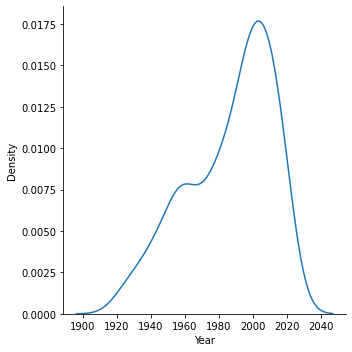

In [43]:
# Graphical meausre of the distribution shape is Histogram
display(sns.displot(df['Year'], kind = "kde"))


From above histogram, we can see that the YEAR variable is left skewed.

In [44]:
# Numerical meausre of the distribution shape is : skewness
df['Year'].skew()

-0.6793771775494065

Skewness value is : -0.679. Negative value implies that YEAR is left skewed. As skweness is not less than -1, we can say that YEAR is moderately skewed to Left.

We can conclude that, there are very few movies among top 250 imdb movies which were released around 1920.

# 3- MEASURE OF CENTRAL TENDENCY

In [45]:
# mean
df['Year'].mean()

1986.488

In [46]:
#median
df['Year'].median()

1994.0

In [47]:
#mode
df['Year'].mode()

0   1995.0
dtype: float64

Note: YEAR is asymmetric, so the better measure of the central tendency is median.

The movie release years are clustered around 1994
50 percent of the top 250 imdb movies were released on or before 1994.


Mazority of the top 250 imdb movies were released in year 1995.

In [48]:
# finding maximum movies released in a Year that make in top 250 imdb list.
m=0
for x in df['Year']:
    if x==1995:
        m+=1
print(m)

8


In 1995, total 8 movies got their listing in imdb top 250 movie list.
Producing 8 great movies in a single year is marvelous.

# 4- PERCENTILES

In [49]:
# percentiles

print(df['Year'].quantile(0.10))
print(df['Year'].quantile(0.25))
print(df['Year'].quantile(0.50))
print(df['Year'].quantile(0.75))
print(df['Year'].quantile(0.90))

1949.8999999999999
1966.25
1994.0
2006.75
2015.0


10 percent of the top 250 imdb movies were released on or before 1950

25 percent of the top 250 imdb movies were released on or before 1966

50 percent of the top 250 imdb movies were released on or before 1994

75 percent of the top 250 imdb movies were released on or before 2006

# 5- MEASURE OF VARIABILITY

In [50]:
df['Year'].var()

636.3151164658641

In [51]:
df['Year'].std()

25.225287242484754

The standard deviation is more relatable. It’s like saying, "If you pick a movie at random from the top 250 IMDb movies, you can expect its release year to be roughly 25 years earlier or later than the average release year of the list. This range covers the bulk of the movies, but there might be some that are even further away from the average."

In short, the standard deviation of 25.22 tells you that there is a spread of about 25 years in the release dates of movies around the average release year, and that's the number to focus on for a general understanding of the data's spread.

# 6- FIVE NUMBER SUMMARY (BOX PLOT)

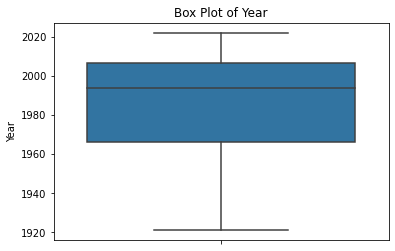

Minimum:  1921.0
1st Quartile (25%):  1966.25
Median (50%):  1994.0
3rd Quartile (75%):  2006.75
Maximum:  2022.0


In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a box plot of the 'Year' column from the DataFrame
sns.boxplot(y=df["Year"])

# Adding labels and title
plt.ylabel("Year")
plt.title("Box Plot of Year")

# Show plot
plt.show()

# Calculating the five-number summary
summary = df["Year"].describe()

# Printing the five-number summary
print("Minimum: ", summary["min"])
print("1st Quartile (25%): ", summary["25%"])
print("Median (50%): ", summary["50%"])
print("3rd Quartile (75%): ", summary["75%"])
print("Maximum: ", summary["max"])


# DURATION

# 1- OUTLIER DETECTION

In [53]:
# Using Zscore( usually we use this method to find the outlier when the data is symmetric, is not  more, we can
#use this method to detect the outliers)

Year_zscore = list(np.round(stats.zscore(df['duration']), 2))
index=[]
outlier=[]
for i in range(len(Year_zscore)):
    if Year_zscore[i]<-3 or Year_zscore[i]>3:
        outlier.append(Year_zscore[i])
        index.append(i)

print(index)
print(outlier)

[192]
[15.53]


In [54]:
# Outlier Detection using IQR

index=[]
outlier=[]
percentile25 = df['duration'].quantile(0.25)
percentile75 = df['duration'].quantile(0.75)
iqr= percentile75-percentile25
upper = percentile75 + 1.5 * iqr
lower = percentile25 - 1.5 * iqr
for i in range(len(df['duration'])):
    if (df['duration'][i]>upper) or (df['duration'][i]<lower):
        outlier.append(df['duration'][i])
        index.append(i)
        
print(index)
print(outlier)

#note: these methods are giving us outliers, they are providing us the verhu high and very low values which have the potential
# to be an outlier. Outlier is an incorrect observation. For every potential outlier we verify if it is correct or not and based on this, we declare it as an outlier.

[19, 80, 95, 158, 182, 192]
[207.0, 229.0, 218.0, 238.0, 212.0, 2700.0]


<AxesSubplot:xlabel='duration'>

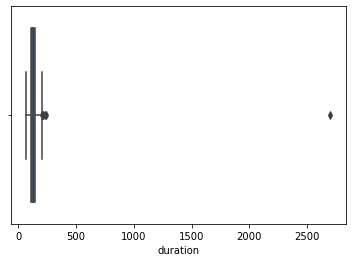

In [55]:
# Outlier Detection using BOX PLOT (Outlier Detection using IQR graphically)

sns.boxplot(x=df["duration"])


we can see that, only duration 2700.0 is not making any sense, a movie can not be that long. So, we have recorded 
the false duration time for the movie at index 192. The movie is :  "Sherlock Jr."

In [56]:
# removing outlier, we have to subsitute a correct value or a value near to it,otherwise we have to drop that observation(row) 

df.duration=np.where(df.duration==2700,45, df.duration) 

we can find the correct movie duration from imdb website, above we can see that 45 minutes is a correct movie duration.

# 2- MEASURE OF DISTRIBUTION SHAPE

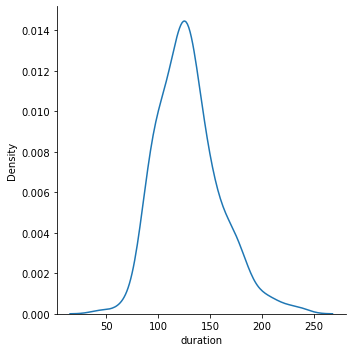

In [57]:
# Graphical meausre of the distribution shape is Histogram

display(sns.displot(df['duration'], kind = "kde"))

we can see that there are some movies whose duration is also less than 50 and for some it is even more than 180 minutes, means more than 3 hours.

In [58]:
# Numerical meausre of the distribution shape is : skewness

print(df['duration'].skew())

0.6943959554643999


In [59]:
(a,b)= (df['duration'].mean() - df['duration'].std()),(df['duration'].mean() + df['duration'].std())
print(a,",",b)

(c,d)= (df['duration'].mean() - 2*df['duration'].std()),(df['duration'].mean() + 2*df['duration'].std())
print(c,",",d)

(e,f)= (df['duration'].mean() - 3*df['duration'].std()),(df['duration'].mean() + 3*df['duration'].std())
print(e,",",f)

98.94843001095818 , 158.9795699890418
68.93286002191635 , 188.99513997808364
38.91729003287453 , 219.01070996712548


#68–95–99 rule ( not taken 99.7 as data is not fully symmetric)

Around 68 percent of the top 250 imdb movies have total duration between 99 and 159 minutes.

Around 95 percent of the top 250 imdb movies have total duration between 69 and 189 minutes.

Around 99 percent of the top 250 imdb movies have total duration between 39 and 220 minutes.

# 3- MEASURE OF CENTRAL TENDENCY

In [60]:
# mean
print(df['duration'].mean())

128.964


In [61]:
#median
print(df['duration'].median())

126.5


The movie duration is little asymmetric, so the better measure for central location is median.

The movie durations are clustered around 127 minutes. Median is a central vale. Central value divides the total observations in two halves.

let say, we decided to make a movie and our aimm to get our movie in top 250 list. Then we try to make movie of length around 
127 minutes.

50 percent of the top 250 imdb movies having the running time less than 127 minutes and rest 50 percent have the running time more than 127 minutes.


# 4- PERCENTILES

In [62]:
# percentiles

print(df['duration'].quantile(0.10))
print(df['duration'].quantile(0.25))
print(df['duration'].quantile(0.50))
print(df['duration'].quantile(0.75))
print(df['duration'].quantile(0.90))

93.89999999999999
107.25
126.5
145.0
170.0


10 percent of the top 250 imdb movies have their running time less than or equal to 94 minutes

90 percent of the top 250 imdb movies have their running time more than 94 minutes. (imp)

25 percent of the top 250 imdb movies have their running time less than or equal to 107 minutes

50 percent of the top 250 imdb movies have their running time less than or equal to 127 minutes

75 percent of the top 250 imdb movies have their running time less than or equal to 145 minutes

10 percent of the top 250 imdb movies have their running time more than 170 minutes.(imp)

50 percent of the top 250 imdb movies have their running time between 107 and 145 minutes (imp)


# 5- MEASURE OF VARIABILITY

In [63]:
# numeric measures of variablity, it is always a good idea to compare the variation using numerical measure with histogram
print(df['Year'].var())
print(df['Year'].std())
print(df['duration'].quantile(0.75)- df['duration'].quantile(0.25))

636.3151164658641
25.225287242484754
37.75


In [64]:
# breaking duration in 2 groups in order to compare the duration variation among these 2  groups.


duration_year_less2000= df.iloc[np.where(df['Year'] <= 2000)]['duration']
duration_year_more2000= df.iloc[np.where(df['Year'] > 2000)]['duration']

In [65]:
print(duration_year_less2000.quantile(0.75)- duration_year_less2000.quantile(0.25))
print(duration_year_more2000.quantile(0.75)- duration_year_more2000.quantile(0.25))


38.5
33.25


IQR FOR DURATION OF MOVIES WHICH WERE RELEASED ON AND BEFORE YEAR 2000 HAVE MORE IQR FOR DURATION OF MOVIES WHICH WERE RELEASED AFTER YEAR 2000.

SO, THE MOVIES WHICH WERE RELEASED ON AND BEFORE YEAR 2000 HAVE MORE VARIATION IN THEIR RUNNING TIME THEN THE VARIATION IN RUNNING TIME FOR THOSE MOVIES WHICH WERE RELEASED AFTER YEAR 2000.

Let's try to vizualize the variation:

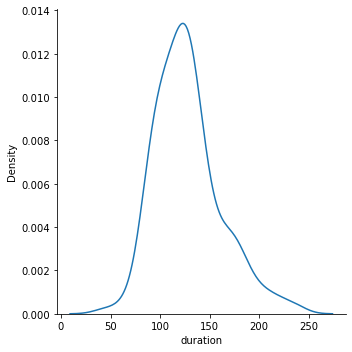

In [66]:
display(sns.displot(duration_year_less2000, kind = "kde"))

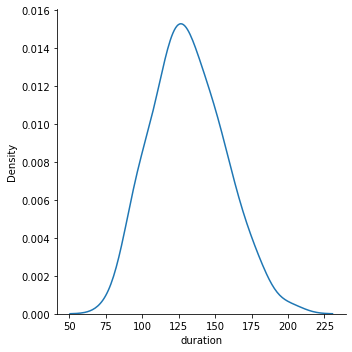

In [67]:
display(sns.displot(duration_year_more2000, kind = "kde"))

In [68]:
print(duration_year_more2000.describe())

count    92.0
mean    131.4
std      24.3
min      80.0
25%     115.0
50%     130.0
75%     148.2
max     201.0
Name: duration, dtype: float64


In [69]:
print(duration_year_less2000.describe())

count   158.0
mean    127.5
std      32.9
min      45.0
25%     103.5
50%     124.5
75%     142.0
max     238.0
Name: duration, dtype: float64


Movies which were released after year 2000, none of them have their running time more than 201 minutes, infact around 99 percent movies have their running time less than or equal to 3 hours.

Around 5 percent of the movies released after year 2000 are atleast 3 hours long, and around 9.5 percent of movies which were released before 2000 are atleast 3 hours long.
After 2000, the trend of having movies longer than 3 hours gone down.



In [70]:
movies_longer_3hours =0

for x in duration_year_more2000:
    if x>175:
        movies_longer_3hours+=1
        
print("percent of movies longer than 3 hours after year 2000 : ", (movies_longer_3hours/ len(duration_year_more2000))*100)

movies_longer_3hours =0

movies_longer_3hours =0

for x in duration_year_less2000:
    if x>175:
        movies_longer_3hours+=1

print("percent of movies longer than 3 hours before year 2000 : ",(movies_longer_3hours/len(duration_year_less2000))*100)

percent of movies longer than 3 hours after year 2000 :  5.434782608695652
percent of movies longer than 3 hours before year 2000 :  9.49367088607595


# 6- FIVE NUMBER SUMMARY (BOX PLOT)

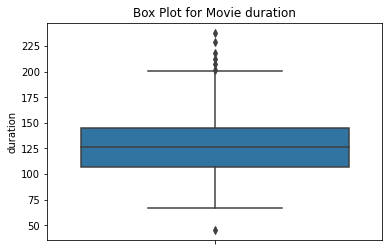

Minimum duration:  45.0
1st Quartile (25%):  107.25
Median (50%):  126.5
3rd Quartile (75%):  145.0
Maximum duration:  238.0


In [71]:
sns.boxplot(y=df["duration"])

# Adding labels and title
plt.ylabel("duration")
plt.title("Box Plot for Movie duration")

# Show plot
plt.show()

# Calculating the five-number summary
summary = df["duration"].describe()

# Printing the five-number summary
print("Minimum duration: ", summary["min"])
print("1st Quartile (25%): ", summary["25%"])
print("Median (50%): ", summary["50%"])
print("3rd Quartile (75%): ", summary["75%"])
print("Maximum duration: ", summary["max"])


# MONTH

# 1- OUTLIER DETECTION

In [72]:
# Outlier Detection using IQR

index=[]
outlier=[]
percentile25 = df['Month'].quantile(0.25)
percentile75 = df['Month'].quantile(0.75)
iqr= percentile75-percentile25
upper = percentile75 + 1.5 * iqr
lower = percentile25 - 1.5 * iqr
for i in range(len(df['Month'])):
    if (df['Month'][i]>upper) or (df['Month'][i]<lower):
        outlier.append(df['Month'][i])
        index.append(i)
        
print(index)
print(outlier)

#note: these methods are giving us outliers, they are providing us the verhu high and very low values which have the potential
# to be an outlier. Outlier is an incorrect observation. For every potential outlier we verify if it is correct or not and based on this, we declare it as an outlier.

[]
[]


# 2- MEASURE OF DISTRIBUTION SHAPE

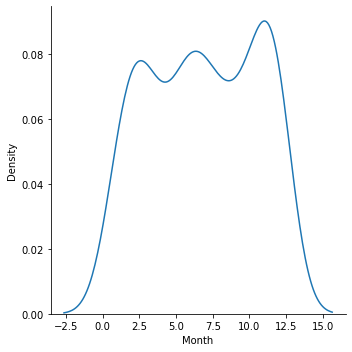

In [73]:
# Graphical meausre of the distribution shape is Histogram



display(sns.displot(df['Month'], kind = "kde"))



In [74]:
# Numerical meausre of the distribution shape is : skewness

print(df['Month'].skew())

-0.07112359862347871


# 3- MEASURE OF CENTRAL TENDENCY

In [75]:
# mean
print(df['Month'].mean())

6.848


In [76]:
#median
print(df['Month'].median())

7.0


In [77]:
#mode
print(df['Month'].mode())

0   12.0
dtype: float64


50 percent of the movies were released on or before july

Most of the top 250 imdb movies were released in December.

# USERS

# 1- OUTLIER DETECTION

In [78]:
# Using Zscore( usually we use this method to find the outlier when the data is symmetric, is not  more, we can
#use this method to detect the outliers)

Year_zscore = list(np.round(stats.zscore(df['Users']), 2))
index=[]
outlier=[]
for i in range(len(Year_zscore)):
    if Year_zscore[i]<-3 or Year_zscore[i]>3:
        outlier.append(Year_zscore[i])
        index.append(i)

print(index)
print(outlier)

[0, 2, 12]
[3.96, 3.9, 3.32]


In [79]:
# Outlier Detection using IQR

index=[]
outlier=[]
percentile25 = df['Users'].quantile(0.25)
percentile75 = df['Users'].quantile(0.75)
iqr= percentile75-percentile25
upper = percentile75 + 1.5 * iqr
lower = percentile25 - 1.5 * iqr
for i in range(len(df['Users'])):
    if (df['Users'][i]>upper) or (df['Users'][i]<lower):
        outlier.append(df['Users'][i])
        index.append(i)
        
print(index)
print(outlier)

#note: these methods are giving us outliers, they are providing us the verhu high and very low values which have the potential
# to be an outlier. Outlier is an incorrect observation. For every potential outlier we verify if it is correct or not and based on this, we declare it as an outlier.

[0, 2, 11, 12]
[2647119.0, 2619064.0, 2091977.0, 2321234.0]


They are the high values, but they are making sense,as ratings can be in millions. So we are not treating them as outliers

# 2- MEASURE OF DISTRIBUTION SHAPE

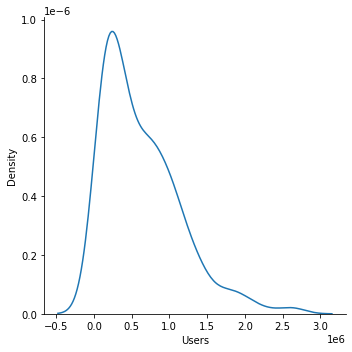

In [80]:
# Graphical meausre of the distribution shape is Histogram


display(sns.displot(df['Users'], kind = "kde"))


From above histogram, we cann see that the USERS is right skewed. So, we can see that the there are some movies which are rated by millions of users.

In [81]:
# Numerical meausre of the distribution shape is : skewness

print(df['Users'].skew())

1.2447144018918606


# 3- MEASURE OF CENTRAL TENDENCY

In [82]:
# mean
print(df['Users'].mean())

631300.24


In [83]:
#median
print(df['Users'].median())

488464.0


488k is a median Users rated for a movie.

When the median for the column "total users rated this movie" is 488,000, it means that half of the movies in the dataset have been rated by fewer than 488,000 users, and the other half have been rated by more than 488,000 users.

# 4- PERCENTILES

In [84]:
# percentiles

print(df['Users'].quantile(0.10))
print(df['Users'].quantile(0.25))
print(df['Users'].quantile(0.50))
print(df['Users'].quantile(0.75))
print(df['Users'].quantile(0.90))
print(df['Users'].quantile(1))

118378.4
215888.0
488464.0
949418.0
1295179.7999999998
2647119.0


25 percent of the top 250 imdb movies got users between 215k and 488k 
10 percent of the top 250 imdb movies got users more than 1.3 million.
There are around 25 out of 250 movies which where rated by more than 1.3 million users.

In [85]:
c=0
for x in df['Users']:
    if x>1300000:
        c+=1

In [86]:
c

25

# 5- MEASURE OF VARIABILITY

In [87]:
# numeric measures of variablity, it is always a good idea to compare the variation using numerical measure with histogram
print(df['Users'].var())
print(df['Users'].std())
print(df['Users'].quantile(0.75)- df['duration'].quantile(0.25))

260482133877.77356
510374.503553786
949310.75


In [88]:
# breaking duration in 2 groups in order to compare the duration variation among these 2  groups.


users_imdb_more_9= df.iloc[np.where(df['Rating'] >=9.0)]['Users']
users_imdb_more_8_9= df.iloc[np.where(df['Rating'] <9.0) and np.where(df['Rating']>=8.0)] ['Users']

In [89]:
print(users_imdb_more_9.quantile(0.75)- users_imdb_more_9.quantile(0.25))
print(users_imdb_more_8_9.quantile(0.75)- users_imdb_more_8_9.quantile(0.25))


935506.5
733530.0


In [90]:
users_imdb_more_9.quantile(0.50)

2226988.0


The total ratings for a movie with imdb 9 or more showing high variation then for movies with imdb rating between 8 and 9.

In [91]:
users_imdb_more_9.std()

670406.4418241618

In [92]:
users_imdb_more_8_9.std()

510374.503553786

# 6- FIVE NUMBER SUMMARY (BOX PLOT)

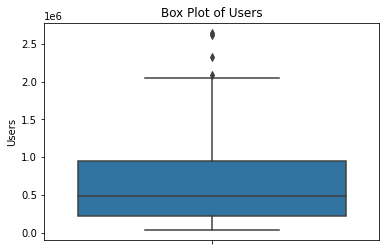

Minimum Users rated :  29676.0
1st Quartile (25%):  215888.0
Median (50%):  488464.0
3rd Quartile (75%):  949418.0
Maximum Users rated:  2647119.0


In [93]:

sns.boxplot(y=df["Users"])

# Adding labels and title
plt.ylabel("Users")
plt.title("Box Plot of Users")

# Show plot
plt.show()

# Calculating the five-number summary
summary = df["Users"].describe()

# Printing the five-number summary
print("Minimum Users rated : ", summary["min"])
print("1st Quartile (25%): ", summary["25%"])
print("Median (50%): ", summary["50%"])
print("3rd Quartile (75%): ", summary["75%"])
print("Maximum Users rated: ", summary["max"])


# ANALYSIS (Part - 2)

# Genre

<AxesSubplot:xlabel='Genre', ylabel='count'>

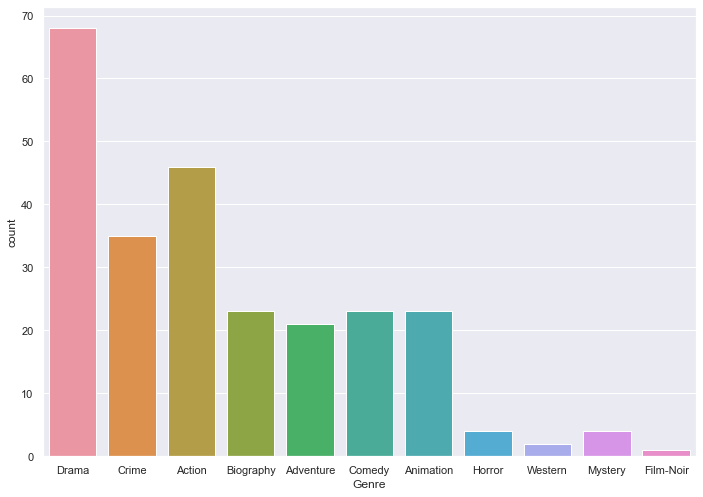

In [94]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.countplot(x=df["Genre"])

We can see that drama movies followed by action movies are in majority among the other genre movies.

More important thing to notice here is that, Horror movies count is similar to the Mystery movies count. 

Also, we can see a tie between Animation and Comedy genre movies.


# Director

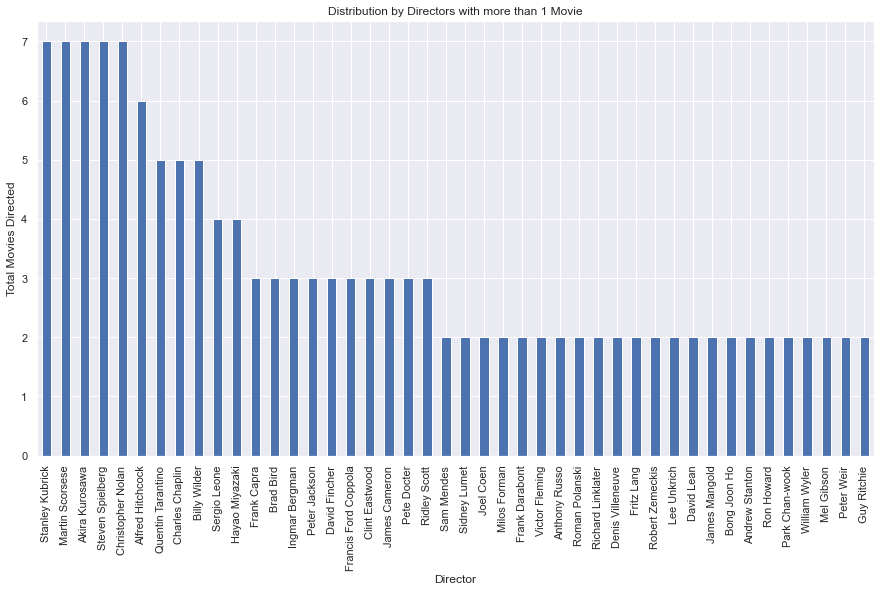

In [132]:
director_counts = df['Director'].value_counts() # series created

# Filter counts greater than 1
filtered_director_counts = director_counts[director_counts > 1] # filtered the series

# Plot the bar chart
plt.figure(figsize=(15, 8))
filtered_director_counts.plot(kind='bar')
plt.xlabel('Director')
plt.ylabel('Total Movies Directed')
plt.title('Distribution by Directors with more than 1 Movie')
plt.show()

Christopher Nolan,  Steven Spielberg, Akira Kurosawa, Martin Scorsese, Stanley Kubrick are the only directors who have directed more than 5 movies that are the part of top 250.

All of these directed 7 movies in total. Out of 250 movies, 35 movies are alone directed by these directors in total, i.e 14 percent of the movies were directed by these 5 gems only.

# Production

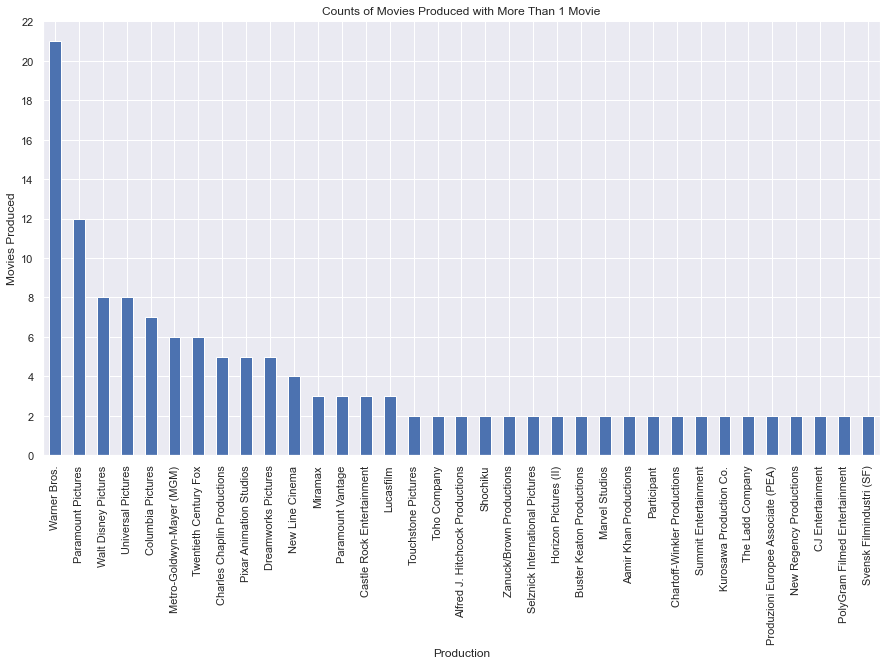

In [137]:

production_counts = df['Production'].value_counts() # series created

# Filter counts greater than 1
filtered_production_counts = production_counts[production_counts > 1] # filtered the series

# Plot the bar chart
plt.figure(figsize=(15, 8))
filtered_production_counts.plot(kind='bar')
plt.xlabel('Production')
plt.ylabel('Movies Produced')
plt.title('Counts of Movies Produced with More Than 1 Movie')

# Set y-axis ticks in multiples of 2
max_count = filtered_production_counts.max()
plt.yticks(range(0, max_count + 2, 2))

plt.show()

8.4 percent of the total top 250 are come from the production house of Warner Bros followed by Paramount Pictures and Walt Disney Pictures.

8.4 percent is a great number, Warner Bros did awesome job.

# CAST

In [167]:
Actor_1 =[]
Actor_2=[]
for x in df['Cast']:
    Actor_1.append(x.split(",")[0].lower())
    Actor_2.append(x.split(",")[1].lower().strip())
Actor_1.extend(Actor_2)

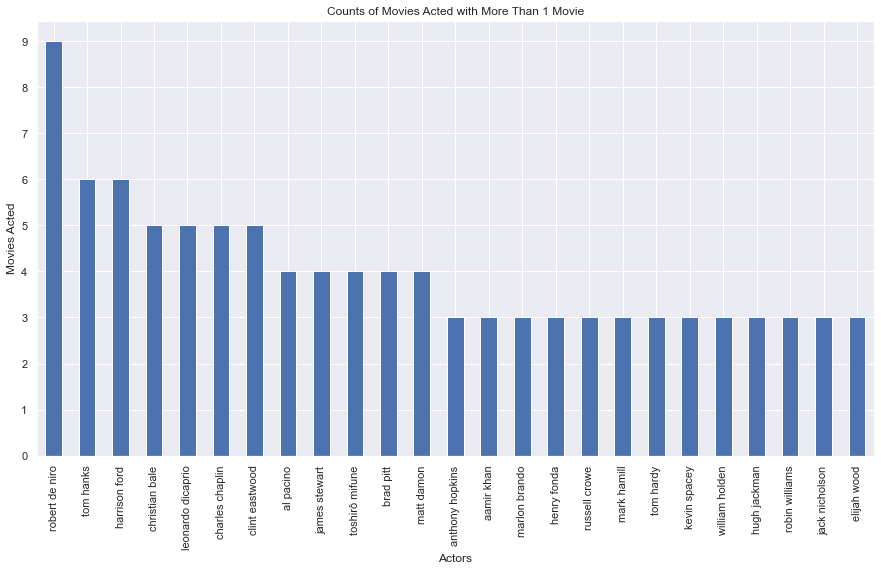

In [168]:
movies_counts = pd.Series(Actor_1).value_counts() 

# Filter counts greater than 1
filtered_movies_counts = movies_counts[movies_counts > 2] # filtered the series

# Plot the bar chart
plt.figure(figsize=(15, 8))
filtered_movies_counts.plot(kind='bar')
plt.xlabel('Actors')
plt.ylabel('Movies Acted')
plt.title('Counts of Movies Acted with More Than 1 Movie')

# Set y-axis ticks in multiples of 2
max_count = filtered_movies_counts.max()
plt.yticks(range(0, max_count + 1, 1))

plt.show()

Lets find out, which actors are the part of most of the movies.

Robert De Niro : He acted in 9 movies, i.e 3.4 percent of movies had him. 9 is a great number, for a reson is among gretest
                 actors.

Tom Hanks: If you have watched "Forest Gump", then this name will not surprise you. Apart from Forest Gump, He was a part of 5            more movies. 
    

In [155]:
act_1= Actor_1
act_2=Actor_2

# creating a actor_combo where actors are sorted 
actor_combo=[]
for i in range(0,250):
    x=act_1[i]
    y=act_2[i]
    if x < y:
        actor_combo.append(x+", "+y)
    else:
        actor_combo.append(y+", "+x)

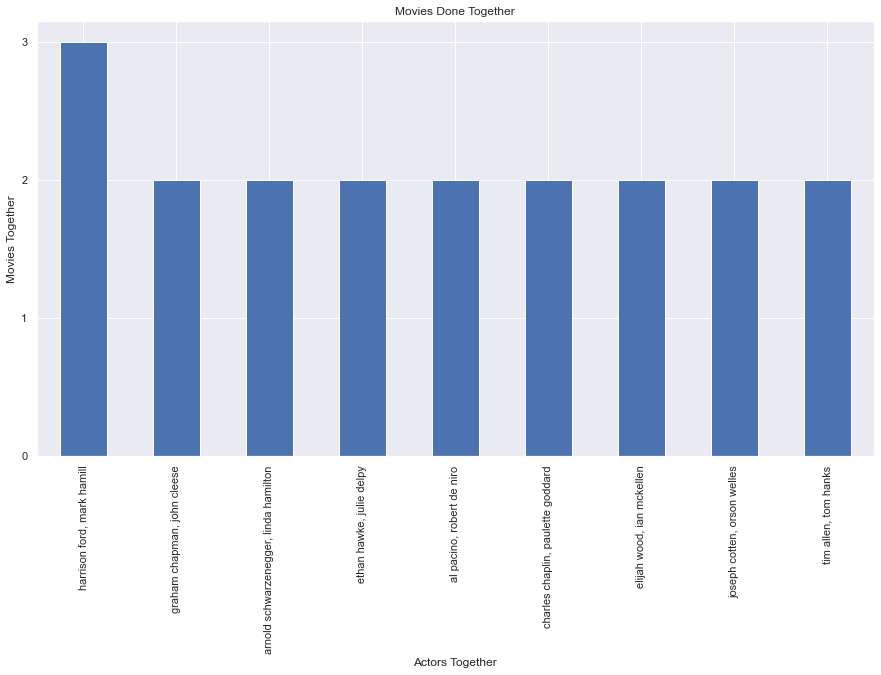

In [158]:
combined_actors_counts= pd.Series(actor_combo).value_counts()
filtered_combined_actors_counts = combined_actors_counts[combined_actors_counts > 1] # filtered the series

# Plot the bar chart
plt.figure(figsize=(15, 8))
filtered_combined_actors_counts.plot(kind='bar')
plt.xlabel('Actors Together')
plt.ylabel('Movies Together')
plt.title('Movies Done Together')

# Set y-axis ticks in multiples of 2
max_count = filtered_combined_actors_counts.max()
plt.yticks(range(0, max_count + 1, 1))

plt.show()

Now, lets see that which combination of actors contributed to this list most.

First name in the combo comes of:

Harrison Ford and Mark Hamill, both have acted in 3 movies together.
    
The pair which have acted together in exactly 2 movies are below:
    
1- Al Pacino and Robert de Niro

2- Elijah Wood and Ian Mckellen

3- Arnold Schwarzenegger and Linda Hamilton

4- Charles Cahplin and Paulette Goddard

5- Tim Allen and Tom Hanks

6- Joseph Cotten and Orson Welles

7- Graham Chaman and John Cleese

8- Ethan Hawke and Julie Delpy

In [172]:
# list all the movies in which Robert De Niero acted

for i in range(df.shape[0]):
    if "Robert De Niro" in df['Cast'][i]:
        print(df["Name"][i])

The Godfather Part II
Goodfellas
Joker
Once Upon a Time in America
Heat
Taxi Driver
Casino
Raging Bull
The Deer Hunter


Lets see, in which movies Robert De Niro acted. Above is the list of those movies.

Godfather made him a superstar and how one can forget "Murry" from "Joker". 

In [173]:
# list all the movies which include both the actors : Mark Hamill, Harrison Ford

for i in range(df.shape[0]):
    if "Mark Hamill" in df['Cast'][i] and "Harrison Ford"  in df['Cast'][i]:
        print(df["Name"][i])


Star Wars: Episode V - The Empire Strikes Back
Star Wars
Star Wars: Episode VI - Return of the Jedi


In [174]:
# list all the movies which include both the actors : Arnold Schwarzenegger, Linda Hamilton

for i in range(df.shape[0]):
    if "Arnold Schwarzenegger" in df['Cast'][i] and "Linda Hamilton"  in df['Cast'][i]:
        print(df["Name"][i])


Terminator 2: Judgment Day
The Terminator


In [105]:
print(df.columns)

Index(['Name', 'Cast', 'Director', 'Production', 'Genre', 'Country', 'Year',
       'Month', 'duration', 'Users', 'US_Canada_Collection',
       'Weekend_Collection', 'Worlwide_Collection', 'Meta_Score', 'Rating',
       'Budget'],
      dtype='object')


# BUDGET Analysis

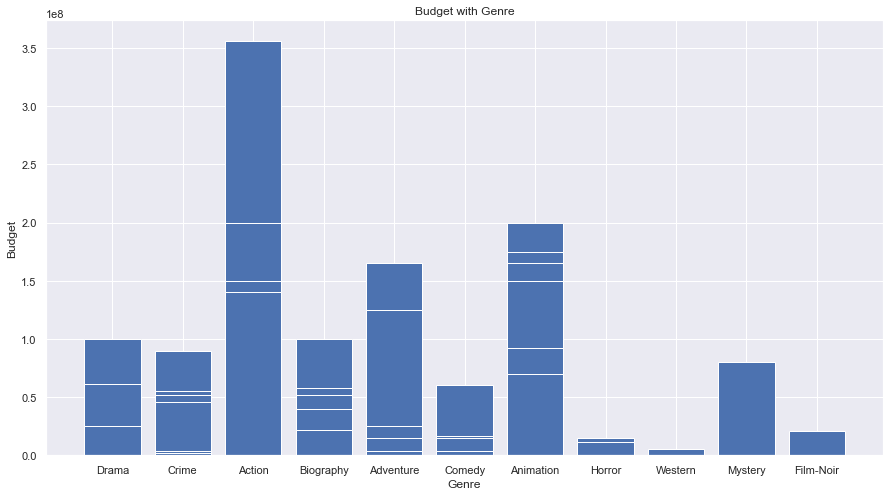

In [176]:
# Budget with Genre

plt.figure(figsize=(15, 8))
plt.bar(df['Genre'], df['Budget'])
plt.xlabel('Genre')
plt.ylabel('Budget')
plt.title('Budget with Genre')

plt.show()


The total budget for the Drama movies are less as comapared to action movies as comapred to the action movies. Action genre is followed by Animation.

In total, the total budget for action movies was around 3.5 Billion dollars and for Animation movies, around 1.9 Billion dollars.

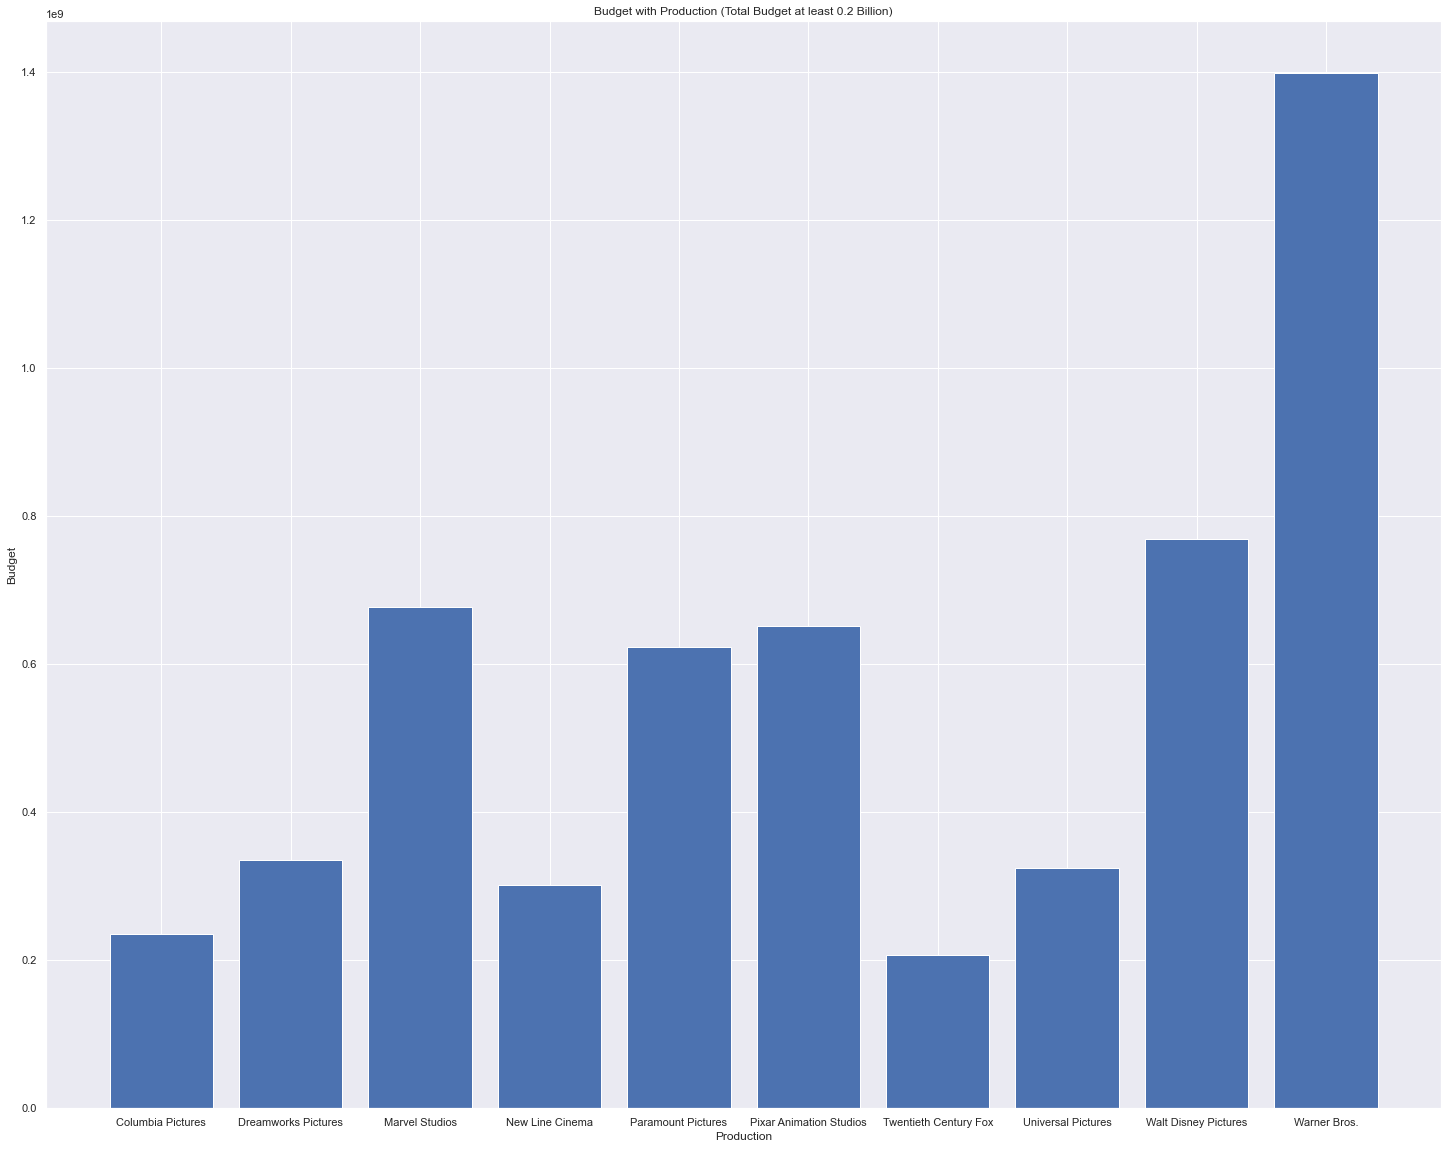

In [182]:
# Budget with Production with atleast 0.2 billion 


# Group by Production and sum the Budget
budget_by_production = df.groupby('Production')['Budget'].sum()

# Filter productions with total budget at least 0.2 billion
budget_threshold = 0.2 * 10**9
filtered_budget_by_production = budget_by_production[budget_by_production >= budget_threshold]

plt.figure(figsize=(25, 20))
plt.bar(filtered_budget_by_production.index, filtered_budget_by_production.values)
plt.xlabel('Production')
plt.ylabel('Budget')
plt.title('Budget with Production (Total Budget at least 0.2 Billion)')

plt.show()


We have seen that Warner Bros has produced 21 movies and Walt disney has produced 8 movies. This made up their total budget of 1.39 billion dollars and 768 million dollars respectively.

But, Paramount pictures have also produced 8 movies in budget of 623 million dollars, which is approx. 150 million dollar less than Disney's budget. The reason behind this can be : that walt disney's favourite genre is Animation.

Lets dive deep for these 3 productions and find out taht in what kind of movies does they spend most.

In [183]:
Warner_Bros_budget=0
for i in range(df.shape[0]):
    if df['Production'][i] == 'Warner Bros.':
        Warner_Bros_budget =Warner_Bros_budget+df['Budget'][i]
        
print(Warner_Bros_budget)
        

1398950000.0


In [184]:
walt_disney_budget=0
for i in range(df.shape[0]):
    if df['Production'][i] == 'Walt Disney Pictures':
        walt_disney_budget = walt_disney_budget+df['Budget'][i]
        
print(walt_disney_budget)
        

768775000.0


In [185]:
for i in range(df.shape[0]):
    if df['Production'][i] == 'Walt Disney Pictures':
        print(df['Name'][i])
        print(df['Genre'][i])
        print(df['Budget'][i])
        print(df['Year'][i])
        print("\n")
        

The Lion King
Animation
45000000.0
1994.0


Toy Story
Animation
30000000.0
1995.0


Coco
Animation
175000000.0
2017.0


Toy Story 3
Animation
200000000.0
2010.0


Hamilton
Biography
775000.0
2020.0


Ratatouille
Animation
150000000.0
2007.0


Pirates of the Caribbean: The Curse of the Black Pearl
Action
140000000.0
2003.0


Aladdin
Animation
28000000.0
1992.0




Disney produced 75 percent Animation movies.

In [186]:
for i in range(df.shape[0]):
    if df['Production'][i] == 'Warner Bros.':
        print(df['Name'][i])
        print(df['Genre'][i])
        print(df['Budget'][i])
        print(df['Year'][i])
        print("\n")
        

The Dark Knight
Action
185000000.0
2008.0


Inception
Action
160000000.0
2010.0


The Matrix
Action
63000000.0
1999.0


Goodfellas
Biography
25000000.0
1990.0


The Departed
Crime
90000000.0
2006.0


Casablanca
Drama
950000.0
1942.0


The Shining
Drama
19000000.0
1980.0


The Dark Knight Rises
Action
250000000.0
2012.0


Joker
Crime
55000000.0
2019.0


A Clockwork Orange
Crime
2200000.0
1971.0


Full Metal Jacket
Drama
30000000.0
1987.0


Heat
Action
60000000.0
1995.0


Batman Begins
Action
150000000.0
2005.0


Unforgiven
Drama
14400000.0
1992.0


The Treasure of the Sierra Madre
Adventure
3000000.0
1948.0


V for Vendetta
Action
54000000.0
2005.0


Dial M for Murder
Crime
1400000.0
1954.0


Million Dollar Baby
Drama
30000000.0
2004.0


Harry Potter and the Deathly Hallows: Part 2
Adventure
125000000.0
2011.0


The Exorcist
Horror
11000000.0
1973.0


The Iron Giant
Animation
70000000.0
1999.0




The interesting thing to notice about the Warner Bros is that, this production house didn't limit itself to only particular type of genre. It has produced Animation, Horror, Adventure, Drama, Crime, Action, Biography.

Warner Bros. has covered all the genres.


### lets do the trended analysis of budget for  Animated movies

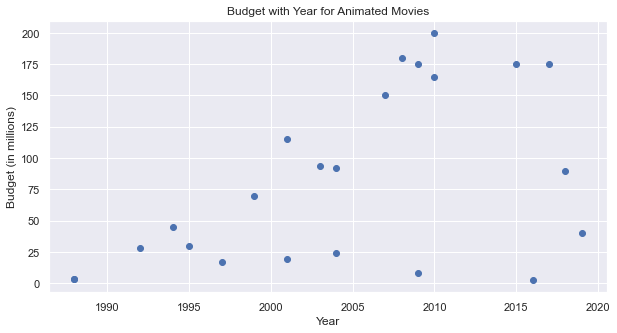

In [188]:
Y = df['Budget'].loc[df['Genre'] == 'Animation']/ 10**6  # Convert budget to millions
X = df['Year'].loc[df['Genre'] == 'Animation']

plt.figure(figsize=(10, 5))
plt.scatter(X, Y)
plt.xlabel('Year')
plt.ylabel('Budget (in millions)')
plt.title('Budget with Year for Animated Movies')

plt.show()


The most expensive animated movies was produced in year 2010, lets find about the details of that movie.

In [116]:
df.iloc[np.where((df['Genre']=="Animation") & (df['Year']== 2010 ))]

,Name,Cast,Director,Production,Genre,Country,Year,Month,duration,Users,US_Canada_Collection,Weekend_Collection,Worlwide_Collection,Meta_Score,Rating,Budget
84,Toy Story 3,"Tom Hanks, Tim Allen",Lee Unkrich,Walt Disney Pictures,Animation,"United States, Japan",2010.0,6.0,103.0,829871.0,415004880.0,110307189.0,1066970811.0,92.0,8.3,200000000.0
200,How to Train Your Dragon,"Jay Baruchel, Gerard Butler",Dean DeBlois,DreamWorks Animation,Animation,"United States, France",2010.0,3.0,98.0,734429.0,217581231.0,43732319.0,494879471.0,75.0,8.1,165000000.0


The movie is : "Toy Story 3", with budget of 200 million dollars. 
For other details of this movie, please refer above table.

# Distribution By Rating

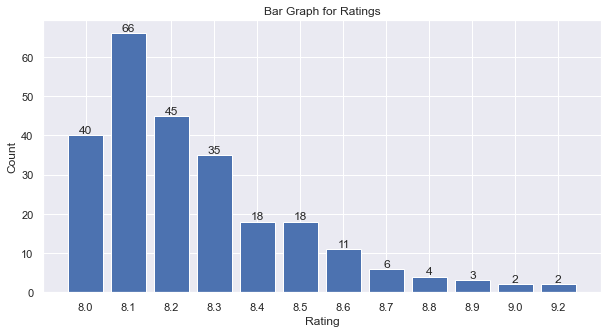

In [191]:
# Count the occurrences of each unique rating
rating_counts = df['Rating'].value_counts()

# Sort by index (rating value)
rating_counts = rating_counts.sort_index()

# Plot the bar graph using Matplotlib
plt.figure(figsize=(10, 5))
bars = plt.bar(rating_counts.index.astype(str), rating_counts.values)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Bar Graph for Ratings')

# Adding the count annotations above the bars
for bar, count in zip(bars, rating_counts.values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, str(count), ha='center', va='bottom')

plt.show()


Only 4 movies among top 250 imdb movies, got the imdb rating 9 or more , 2 got 9 and 2 got 9.2 No movie till now, got more than 9.2 rating.Lets find out these movies details.

In [192]:
df.iloc[np.where(df['Rating']>=9)]

,Name,Cast,Director,Production,Genre,Country,Year,Month,duration,Users,US_Canada_Collection,Weekend_Collection,Worlwide_Collection,Meta_Score,Rating,Budget
0,The Shawshank Redemption,"Tim Robbins, Morgan Freeman",Frank Darabont,Castle Rock Entertainment,Drama,United States,1994.0,10.0,142.0,2647119.0,28767189.0,727327.0,28884504.0,81.0,9.2,25000000.0
1,The Godfather,"Marlon Brando, Al Pacino",Francis Ford Coppola,Paramount Pictures,Crime,United States,1972.0,3.0,175.0,1834912.0,136381073.0,302393.0,250341816.0,100.0,9.2,6000000.0
2,The Dark Knight,"Christian Bale, Heath Ledger",Christopher Nolan,Warner Bros.,Action,"United States, United Kingdom",2008.0,7.0,152.0,2619064.0,534987076.0,158411483.0,1006234167.0,84.0,9.0,185000000.0
3,The Godfather Part II,"Al Pacino, Robert De Niro",Francis Ford Coppola,Paramount Pictures,Crime,United States,1974.0,12.0,202.0,1257549.0,47834595.0,171417.0,47961919.0,90.0,9.0,13000000.0


# Distribution By Month

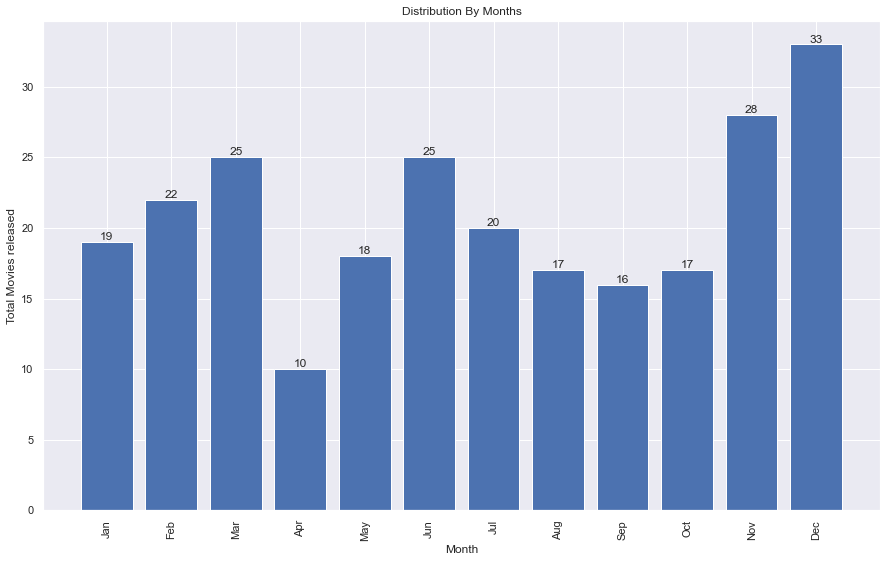

In [199]:

# Count the occurrences of each unique month
month_counts = df['Month'].value_counts()

# Sort by index (month)
month_counts = month_counts.sort_index()

# Map of month numbers to abbreviated names
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Convert month numbers to abbreviated names (ensure month is an integer)
month_labels = [month_names[int(month) - 1] for month in month_counts.index]

# Plot the bar graph using Matplotlib
plt.figure(figsize=(15, 9))
bars = plt.bar(month_labels, month_counts.values)
plt.xlabel('Month')
plt.ylabel('Total Movies released')
plt.title('Distribution By Months')

# Rotate x labels vertically
plt.xticks(rotation='vertical')

# Adding the count annotations above the bars
for bar, count in zip(bars, month_counts.values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, str(count), ha='center', va='bottom')

plt.show()

Most of the top movies released in December. 33 out of 250, i.e around 13 percent of the movies released in month of december.

# Budget and Worldwide Collection for Drama Movies

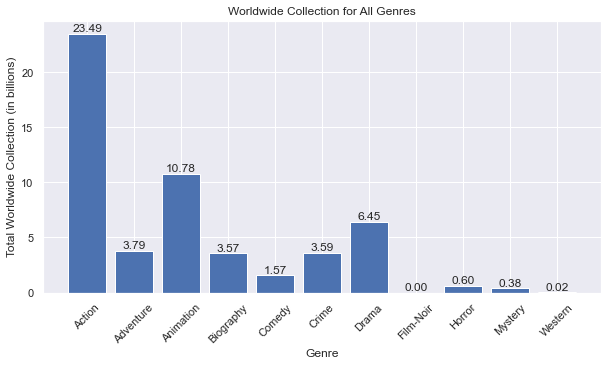

In [203]:
# Group by genre and sum the worldwide collections
genre_collections = df.groupby('Genre')['Worlwide_Collection'].sum()

# Convert to billions
genre_collections = genre_collections / 10**9

# Plot the bar chart using Matplotlib
plt.figure(figsize=(10, 5))
bars = plt.bar(genre_collections.index, genre_collections.values)
plt.xlabel('Genre')
plt.ylabel('Total Worldwide Collection (in billions)')
plt.title('Worldwide Collection for All Genres')

# Adding the collection amounts annotations above the bars
for bar, amount in zip(bars, genre_collections.values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, '{:.2f}'.format(amount), ha='center', va='bottom')

plt.xticks(rotation=45)  # Optional: Rotate x-axis labels for better readability

plt.show()


1-In total among top 250 imdb movies, 68 were drama movies produced with the total budget of around 906 millions dollars and  the world wide collection for these drama movies in genral is  6.45 billions dollar.


let's find that which drama movies did not earn and floped commercially.

In [219]:
df_new= df.loc[np.where(df['Genre']=='Drama')]
df_new =df_new[["Name", "Budget", "Worlwide_Collection" ]]

The drama movies below were not commercially successful

In [220]:
df_new =df_new.iloc[np.where(df_new['Worlwide_Collection'] < df_new['Budget'])]
df_new

,Name,Budget,Worlwide_Collection
58,Sunset Blvd.,1752000.0,300073.0
59,Paths of Glory,935000.0,5252.0
77,The Boat,14528000.0,11487676.0
105,Ikiru,775000.0,96302.0
113,Incendies,6800000.0,6788659.0
115,Metropolis,2724000.0,1349711.0
129,All About Eve,1400000.0,151052.0
133,Judgment at Nuremberg,3000000.0,12180.0
181,Wild Strawberries,562500.0,60418.0
205,Tokyo Story,1875000.0,37880.0


In [221]:
# loss in millions

df_new['Total_Loss'] = (df_new['Budget'] - df_new['Worlwide_Collection']) / 10**6


In [222]:
df_new

,Name,Budget,Worlwide_Collection,Total_Loss
58,Sunset Blvd.,1752000.0,300073.0,1.5
59,Paths of Glory,935000.0,5252.0,0.9
77,The Boat,14528000.0,11487676.0,3.0
105,Ikiru,775000.0,96302.0,0.7
113,Incendies,6800000.0,6788659.0,0.0
115,Metropolis,2724000.0,1349711.0,1.4
129,All About Eve,1400000.0,151052.0,1.2
133,Judgment at Nuremberg,3000000.0,12180.0,3.0
181,Wild Strawberries,562500.0,60418.0,0.5
205,Tokyo Story,1875000.0,37880.0,1.8


The drama movie which faced the highest loss among all the drama movies is "The BOAT",and "Judgment at Nuremberg" with a loss of  approx 2 millions dollars.